In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import json

### Metrics to look at:
* Metrics over time
* Comparison of Hyperparameters
* Metrics at the beginning of training:
    * Why does scaling embeddings screw things up so much? Even when it's just the initialization --> must be an issue at the beginning of training, could be something interesting to look into

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', 999)

In [3]:
def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [4]:
model_path = '../models/'

In [5]:
config_list = []
test_metric_list = []
oos_metric_list = []

def find_metrics_in_dir(base_path):
    for f in os.listdir(base_path):
        print(f)
        if f=='.gitignore': continue
        subdir_path = base_path + f + '/'
        
        if os.path.exists(subdir_path + 'checkpoints/'):
            config_path = subdir_path + 'config.yaml'
            metrics_path = subdir_path + 'metrics_test.json'
            metrics_oos_path = subdir_path + 'metrics_oos.json'

            config_list.append(load_yaml(config_path))
            test_metric_list.append(load_json(metrics_path))
            oos_metric_list.append(load_json(metrics_oos_path))
            
        elif os.path.isdir(subdir_path) and not f=='checkpoints':
            find_metrics_in_dir(subdir_path)

In [6]:
find_metrics_in_dir(model_path)

.gitignore
baseline_base30
baseline_base30_high_attn_init
baseline_base30_no_relative_pe
baseline_base30_repeat_pe
baseline_base30_repeat_pe_qk_only
baseline_base7
baseline_base8
baseline_scale_embeddings


In [7]:
len(config_list), len(test_metric_list), len(oos_metric_list)

(8, 8, 8)

In [8]:
def flatten_config(config_item):
    expanded = {}
    expanded['base'] = config_item['data']['base']
    expanded['train_data'] = config_item['data']['train_path']
    expanded['train_batch_size'] = config_item['loader']['train']['batch_size']
    for k, v in config_item['model_args'].items():
        expanded[k] = v
    expanded['optimizer'] = config_item['optimizer']['type']
    for k, v in config_item['optimizer']['opt_args'].items():
        expanded[k] = v
#     handle all model args
#     handle all opt args
    expanded['n_warmup_steps'] = config_item['scheduler']['n_warmup_steps']
    expanded['nb_epochs'] = config_item['scheduler']['nb_epochs']
    expanded['max_grad_norm'] = config_item['optimizer']['max_grad_norm']
    
    return expanded

In [9]:
configs = [flatten_config(c) for c in config_list]
config_df = pd.DataFrame.from_dict(configs)

In [10]:
config_df

,base,train_data,train_batch_size,attn_weight_xavier_init_constant,dim_feedforward,dropout,embed_dim,extra_positional_encoding_relative_decoder_mha,learn_positional_encoding,max_decode_size,...,relative_positional_encoding,repeat_positional_encoding,scale_embeddings,scale_embeddings_at_init,shared_embeddings,optimizer,lr,n_warmup_steps,nb_epochs,max_grad_norm
0,30,data/train_data_2^16.npy,64,0.5,512,0.05,128,True,False,64,...,True,False,False,False,True,adam,0.001,24000,200,1
1,30,data/train_data_2^16.npy,64,1.0,512,0.05,128,True,False,64,...,True,False,False,False,True,adam,0.001,24000,200,1
2,30,data/train_data_2^16.npy,64,0.5,512,0.05,128,True,False,64,...,False,False,False,False,True,adam,0.001,24000,200,1
3,30,data/train_data_2^16.npy,64,0.5,512,0.05,128,True,False,64,...,False,True,False,False,True,adam,0.001,24000,200,1
4,30,data/train_data_2^16.npy,64,0.5,512,0.05,128,True,False,64,...,False,True,False,False,True,adam,0.001,24000,200,1
5,7,data/train_data_2^16.npy,64,0.5,512,0.05,128,True,False,64,...,True,True,False,False,True,adam,0.001,24000,200,1
6,8,data/train_data_2^16.npy,64,0.5,512,0.05,128,True,False,64,...,True,True,False,False,True,adam,0.001,24000,200,1
7,30,data/train_data_2^16.npy,64,0.5,512,0.05,128,True,False,64,...,True,False,True,False,True,adam,0.001,24000,200,1


In [11]:
def get_nice_metrics(metric_list, suffix = ''):
    correct = pd.DataFrame.from_dict([l['correct'] for l in metric_list])
    n_beams = pd.DataFrame.from_dict([l['meta']['n_beams'] for l in metric_list])
    loss_df = pd.DataFrame.from_dict([l['test_loss'] for l in metric_list])
    n_beams.columns = ['n_beams']
    loss_df.columns = ['loss']
    to_return = [correct, n_beams, loss_df]
    if suffix:
        for tmp_df in to_return:
            tmp_df.columns = [str(c) + f'_{suffix}' for c in tmp_df.columns]
    
    return to_return

In [12]:
merged = pd.concat([config_df] + get_nice_metrics(test_metric_list, 'test') + get_nice_metrics(oos_metric_list, 'oos'), axis=1)

In [13]:
assert (merged['n_beams_test']==merged['n_beams_oos']).all()
merged['n_beams'] = merged['n_beams_oos']
merged.drop(['n_beams_test', 'n_beams_oos'], axis=1, inplace=True)

In [14]:
# Drop all confiuraiton columns that have no variantion b/c that's not super helpful
drop_cols = []
for c in list(config_df) + ['n_beams']:
    if not c in merged: continue
    if merged[c].nunique()==1:
        drop_cols.append(c)
metric_df = merged.drop(drop_cols, axis=1)

In [15]:
metric_df

,base,attn_weight_xavier_init_constant,positional_encoding_query_key_only,relative_positional_encoding,repeat_positional_encoding,scale_embeddings,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,30,0.5,False,True,False,False,0.959168,0.727838,0.070385,0.896973,0.516113,0.070385
1,30,1.0,False,True,False,False,0.934730,0.658470,0.088125,0.859375,0.448242,0.088125
2,30,0.5,False,False,False,False,0.949909,0.659836,0.086440,0.812500,0.414062,0.086440
3,30,0.5,False,False,True,False,0.948543,0.696418,0.079208,0.896484,0.498535,0.079208
4,30,0.5,True,False,True,False,0.960990,0.716302,0.073048,0.917969,0.523926,0.073048
5,7,0.5,False,True,True,False,0.874772,0.259259,0.181037,0.643555,0.177734,0.181037
6,8,0.5,False,True,True,False,0.985580,0.398452,0.150913,0.394531,0.116699,0.150913
7,30,0.5,False,True,False,True,0.960231,0.716910,0.073398,0.922363,0.522461,0.073398


In [16]:
metrics = ['correct_product', 'correct_factorization', 'loss']
splits = ['test', 'oos']
metrics_full = [f'{metric}_{split}' for split in splits for metric in metrics]

In [17]:
metrics_full

['correct_product_test',
 'correct_factorization_test',
 'loss_test',
 'correct_product_oos',
 'correct_factorization_oos',
 'loss_oos']

In [18]:
metric_df

,base,attn_weight_xavier_init_constant,positional_encoding_query_key_only,relative_positional_encoding,repeat_positional_encoding,scale_embeddings,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,30,0.5,False,True,False,False,0.959168,0.727838,0.070385,0.896973,0.516113,0.070385
1,30,1.0,False,True,False,False,0.934730,0.658470,0.088125,0.859375,0.448242,0.088125
2,30,0.5,False,False,False,False,0.949909,0.659836,0.086440,0.812500,0.414062,0.086440
3,30,0.5,False,False,True,False,0.948543,0.696418,0.079208,0.896484,0.498535,0.079208
4,30,0.5,True,False,True,False,0.960990,0.716302,0.073048,0.917969,0.523926,0.073048
5,7,0.5,False,True,True,False,0.874772,0.259259,0.181037,0.643555,0.177734,0.181037
6,8,0.5,False,True,True,False,0.985580,0.398452,0.150913,0.394531,0.116699,0.150913
7,30,0.5,False,True,False,True,0.960231,0.716910,0.073398,0.922363,0.522461,0.073398


In [19]:
def make_correlation_plot(metric_df, x, y):
    metric_df.plot.scatter(x=x, y=y)
    
    x_col = metric_df[x]
    y_col = metric_df[y]
    
    m, b = np.polyfit(x_col, y_col, 1)
    ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    plt.plot(x_vals, m*x_vals + b, color='black', linestyle='--', alpha=.5)
    plt.title(f'Correlation between {x} and {y}')
    plt.show()

### Look at some correlations
#### In general:
* Correlation using correct_product is not very strong in many places.
    * I think this makes sense because of the issue where when the model is unable to factor the number, it returns the number because it could be prime

#### Test metrics vs OoS Metrics:
* Test loss is very correlated with Oos. Same for factorization, but not quite as much

#### Is loss correlated of correct factorizatoin?
* Yes! Loss is very correlated with correct factorization

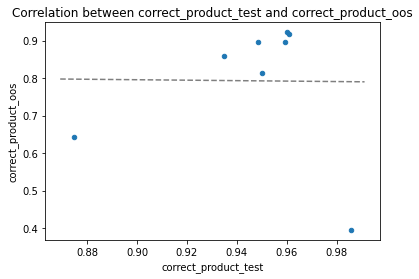

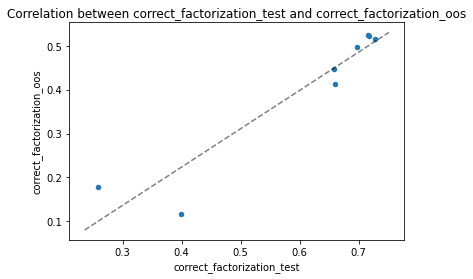

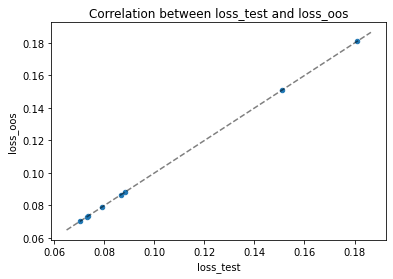

In [20]:
for m in metrics:
    make_correlation_plot(metric_df, x=m + f'_{splits[0]}', y=m + f'_{splits[1]}')

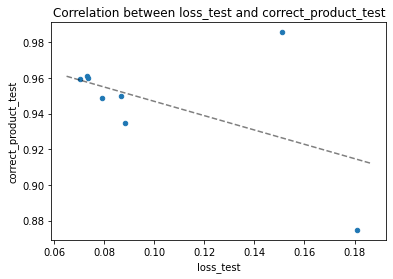

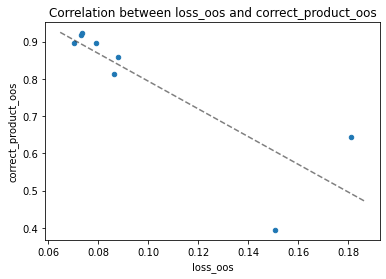

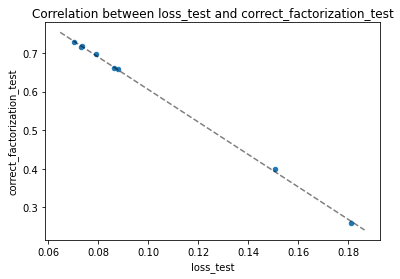

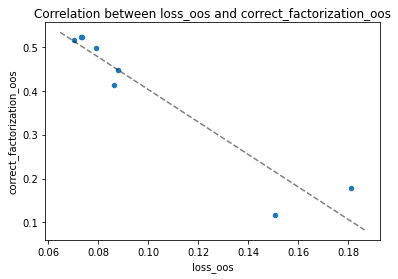

In [21]:
for m in metrics:
    if m == 'loss' : continue
    for s in splits:
        make_correlation_plot(metric_df, x=f'loss_{s}', y = f'{m}_{s}')

In [22]:
def plot_crossed_values(df, groupby_col, cross_col, metric_cols, metrics=None, num_columns = 4):
    if not metrics:
        metrics = {c: 'mean' for c in metric_cols}
    elif isinstance(metrics, list):
        metrics = {c: m for c, m in enumerate(metric_cols, metrics)}
    
    num_metrics = len(metric_cols)
    num_rows = num_metrics // num_columns + num_metrics % num_columns
    if num_rows==1:
        num_columns = num_metrics
        
    fig = plt.gcf()
    fig.set_size_inches(8*num_rows, 2*num_columns)
    
    
    grouped_by_cross = df.groupby(cross_col)

    for i, (metric, function) in enumerate(metrics.items()):
        ax = fig.add_subplot(num_rows, num_columns, 1+i)
        ax.set_title('%s'%metric)
        ax.set_ylabel('%s'%metric)
        for cross_name, cross_df in grouped_by_cross:
            cross_df = cross_df.groupby(groupby_col).agg('mean')
#             cross_df.set_index(groupby_col, inplace=True)
            cross_df[metric].plot(ax=ax, legend=False, label='%s: '%cross_col + str(cross_name), marker='x')
        ax.legend()
        
    fig.tight_layout()
    plt.show()
    
    

plot_crossed_values(metric_df, 'base', 'n_beams', metric_cols)

In [23]:
def plot_single_value(df, groupby_col, metric_cols, metrics=None):
    if not metrics:
        metrics = {c: 'mean' for c in metric_cols}
    elif isinstance(metrics, list):
        metrics = {c: m for c, m in enumerate(metric_cols, metrics)}
    
    num_metrics = len(metric_cols)
    num_rows = num_metrics // num_columns + num_metrics % num_columns
    if num_rows==1:
        num_columns = num_metrics
        
    fig = plt.gcf()
    fig.set_size_inches(8*num_rows, 2*num_columns)
    grouped_by_target = df.groupby(groupby_col)
    for i, (metric, function) in enumerate(metrics.items()):
        ax = fig.add_subplot(num_rows, num_columns, 1+i)
        ax.set_title('%s'%metric)
        ax.set_ylabel('%s'%metric)
        grouped_by_target.agg({metric : function}).plot(ax=ax, legend=False, marker='x')
    fig.tight_layout()
    plt.show()
    
    

In [24]:
metric_df

,base,attn_weight_xavier_init_constant,positional_encoding_query_key_only,relative_positional_encoding,repeat_positional_encoding,scale_embeddings,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,30,0.5,False,True,False,False,0.959168,0.727838,0.070385,0.896973,0.516113,0.070385
1,30,1.0,False,True,False,False,0.934730,0.658470,0.088125,0.859375,0.448242,0.088125
2,30,0.5,False,False,False,False,0.949909,0.659836,0.086440,0.812500,0.414062,0.086440
3,30,0.5,False,False,True,False,0.948543,0.696418,0.079208,0.896484,0.498535,0.079208
4,30,0.5,True,False,True,False,0.960990,0.716302,0.073048,0.917969,0.523926,0.073048
5,7,0.5,False,True,True,False,0.874772,0.259259,0.181037,0.643555,0.177734,0.181037
6,8,0.5,False,True,True,False,0.985580,0.398452,0.150913,0.394531,0.116699,0.150913
7,30,0.5,False,True,False,True,0.960231,0.716910,0.073398,0.922363,0.522461,0.073398


In [25]:
metrics_full

['correct_product_test',
 'correct_factorization_test',
 'loss_test',
 'correct_product_oos',
 'correct_factorization_oos',
 'loss_oos']

In [26]:
hyperparam_cols = [c for c in metric_df.columns if not c in metrics_full]

In [27]:
hyperparam_cols

['base',
 'attn_weight_xavier_init_constant',
 'positional_encoding_query_key_only',
 'relative_positional_encoding',
 'repeat_positional_encoding',
 'scale_embeddings']

In [28]:
metrics_lower_is_better = {'loss'}

def style_col(col, n_highlight=3):
    if len(set(col.name.split('_')).intersection(metrics_lower_is_better)):
        top_indicies = np.argsort(col.values)[:n_highlight]
    else:
        top_indicies = np.argsort(col.values)[::-1][:n_highlight]
    alphas = np.zeros(len(col))
    for i in range(len(top_indicies)):
        alphas[top_indicies[i]] = 1 - i/n_highlight
    return [f'background-color: rgba(0,169,0,{alphas[i]})' for i in range(len(col))]


# @interact
# def style_filter()




In [29]:
metric_df.sort_values(hyperparam_cols).style.apply(style_col, axis=0, subset=metrics_full)

,base,attn_weight_xavier_init_constant,positional_encoding_query_key_only,relative_positional_encoding,repeat_positional_encoding,scale_embeddings,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
5,7,0.500000,False,True,True,False,0.874772,0.259259,0.181037,0.643555,0.177734,0.181037
6,8,0.500000,False,True,True,False,0.985580,0.398452,0.150913,0.394531,0.116699,0.150913
2,30,0.500000,False,False,False,False,0.949909,0.659836,0.086440,0.812500,0.414062,0.086440
3,30,0.500000,False,False,True,False,0.948543,0.696418,0.079208,0.896484,0.498535,0.079208
0,30,0.500000,False,True,False,False,0.959168,0.727838,0.070385,0.896973,0.516113,0.070385
7,30,0.500000,False,True,False,True,0.960231,0.716910,0.073398,0.922363,0.522461,0.073398
4,30,0.500000,True,False,True,False,0.960990,0.716302,0.073048,0.917969,0.523926,0.073048
1,30,1.000000,False,True,False,False,0.934730,0.658470,0.088125,0.859375,0.448242,0.088125


In [30]:
check_hyperparam = 'attn_weight_xavier_init_constant'
groupby_hps = [c for c in hyperparam_cols if not c==check_hyperparam]

In [31]:
grouped = metric_df.groupby(groupby_hps)
grouped = grouped.filter(lambda x: len(x) > 1)
grouped = grouped[[c for c in metric_df.columns if not c in groupby_hps]]
grouped.style.apply(style_col, axis=0, subset=metrics_full, n_highlight=1)

,attn_weight_xavier_init_constant,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,0.500000,0.959168,0.727838,0.070385,0.896973,0.516113,0.070385
1,1.000000,0.934730,0.658470,0.088125,0.859375,0.448242,0.088125
